# Predicting Flight Delays with sklearn

In this notebook, we will be using features we've prepared in PySpark to predict flight delays via regression and classification.

In [1]:
import sys, os, re
sys.path.append("lib")
import utils

import numpy as np
import sklearn
import iso8601
import datetime
print("Imports loaded...")

Imports loaded...


## Load and Inspect our JSON Training Data

In [2]:
# Load and check the size of our training data. May take a minute.
print("Original JSON file size: {:,} Bytes".format(os.path.getsize("../data/simple_flight_delay_features.jsonl")))
training_data = utils.read_json_lines_file('../data/simple_flight_delay_features.jsonl')
print("Training items: {:,}".format(len(training_data))) # 5,714,008
print("Data loaded...")

Original JSON file size: 1,676,709,758 Bytes
Training items: 5,714,008
Data loaded...


In [3]:
# Inspect a record before we alter them
print("Size of training data in RAM: {:,} Bytes".format(sys.getsizeof(training_data))) # 50MB
print(training_data[0])

Size of training data in RAM: 50,897,424 Bytes
{'DayOfWeek': 4, 'ArrDelay': 13.0, 'Dest': 'DFW', 'FlightDate': '2014-12-31T16:00:00.000-08:00', 'Carrier': 'AA', 'Distance': 569.0, 'FlightNum': '1024', 'CRSArrTime': '2015-01-01T10:10:00.000-08:00', 'CRSDepTime': '2015-01-01T07:30:00.000-08:00', 'DayOfMonth': 1, 'DayOfYear': 1, 'DepDelay': 14.0, 'Origin': 'ABQ'}


## Sample our Data

In [4]:
# We need to sample our data to fit into RAM
training_data = np.random.choice(training_data, 1000000) # 'Sample down to 1MM examples'
print("Sampled items: {:,} Bytes".format(len(training_data)))
print("Data sampled...")

Sampled items: 1,000,000 Bytes
Data sampled...


## Vectorize the Results (y)

In [5]:
# Separate our results from the rest of the data, vectorize and size up
results = [record['ArrDelay'] for record in training_data]
results_vector = np.array(results)
print("Results vectorized size: {:,}".format(sys.getsizeof(results_vector))) # 45,712,160 bytes
print("Results vectorized...")

Results vectorized size: 8,000,096
Results vectorized...


## Prepare Training Data

In [6]:
# Remove the two delay fields and the flight date from our training data
for item in training_data:
  item.pop('ArrDelay', None)
  item.pop('FlightDate', None)
print("ArrDelay and FlightDate removed from training data...")

ArrDelay and FlightDate removed from training data...


In [7]:
# Must convert datetime strings to unix times
for item in training_data:
  if isinstance(item['CRSArrTime'], str):
    dt = iso8601.parse_date(item['CRSArrTime'])
    unix_time = int(dt.timestamp())
    item['CRSArrTime'] = unix_time
  if isinstance(item['CRSDepTime'], str):
    dt = iso8601.parse_date(item['CRSDepTime'])
    unix_time = int(dt.timestamp())
    item['CRSDepTime'] = unix_time
print("CRSArr/DepTime converted to unix time...")

CRSArr/DepTime converted to unix time...


## Vectorize Training Data with `DictVectorizer`

In [8]:
# Use DictVectorizer to convert feature dicts to vectors
from sklearn.feature_extraction import DictVectorizer

print("Sampled dimensions: [{:,}]".format(len(training_data)))
vectorizer = DictVectorizer()
training_vectors = vectorizer.fit_transform(training_data)
print("Size of DictVectorized vectors: {:,} Bytes".format(training_vectors.data.nbytes))
print("Training data vectorized...")

Sampled dimensions: [1,000,000]
Size of DictVectorized vectors: 87,539,400 Bytes
Training data vectorized...


## Prepare Experiment by Splitting Data into Train/Test

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
  training_vectors,
  results_vector,
  test_size=0.1,
  random_state=43
)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
print("Test train split performed...")

(900000, 7436) (100000, 7436)
(900000,) (100000,)
Test train split performed...


## Train our Model(s) on our Training Data

In [10]:
# Train a regressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error, r2_score
print("Regressor library and metrics imported...")

Regressor library and metrics imported...


In [11]:
regressor = LinearRegression()
print("Regressor instantiated...")

Regressor instantiated...


In [12]:
from sklearn.ensemble import GradientBoostingRegressor

regressor = GradientBoostingRegressor
print("Swapped gradient boosting trees for linear regression!")

# Lets go back for now...
regressor = LinearRegression()
print("Swapped back to linear regression!")

Swapped gradient boosting trees for linear regression!
Swapped back to linear regression!


In [13]:
regressor.fit(X_train, y_train)
print("Regressor fitted...")

Regressor fitted...


## Predict Using the Test Data

In [14]:
predicted = regressor.predict(X_test)
print("Predictions made for X_test...")

Predictions made for X_test...


## Evaluate and Visualize Model Accuracy

In [15]:
from sklearn.metrics import median_absolute_error, r2_score

# Median absolute error is the median of all absolute differences between the target and the prediction.
# Less is better, more indicates a high error between target and prediction.
medae = median_absolute_error(y_test, predicted)
print("Median absolute error:    {:.3g}".format(medae))

# R2 score is the coefficient of determination. Ranges from 1-0, 1.0 is best, 0.0 is worst.
# Measures how well future samples are likely to be predicted.
r2 = r2_score(y_test, predicted)
print("r2 score:                 {:.3g}".format(r2))

Median absolute error:    9.68
r2 score:                 0.828


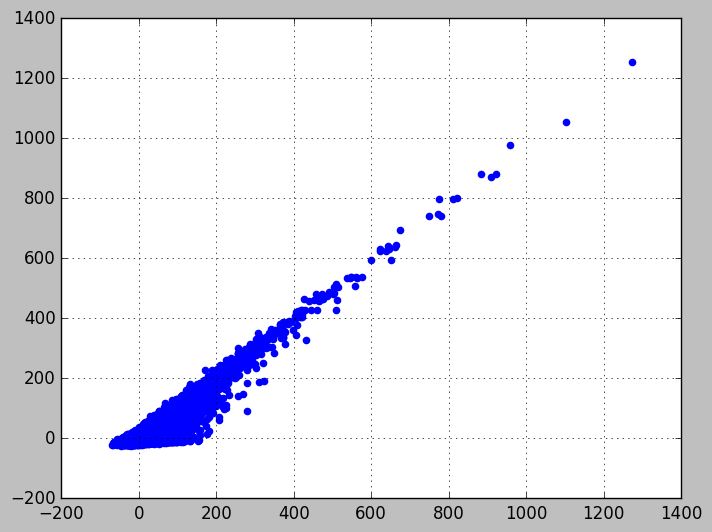

In [111]:
# Plot outputs
import matplotlib.pyplot as plt

# Cleans up the appearance
plt.rcdefaults()

plt.scatter(
  y_test,
  predicted,
  color='blue',
  linewidth=1
)
plt.grid(True)

plt.xticks()
plt.yticks()

plt.show()